<a href="https://colab.research.google.com/github/talgalper/Honours-2021/blob/main/wilcoxon_stat_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install ncbi-blast+
!apt-get install exonerate
!apt-get install dssp
!pip install biostructmap

In [ ]:
import pandas as pd
from collections import defaultdict
import biostructmap
import seaborn as sns; sns.set_theme()
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
#read in data file and file in gaps with 0 values
def nextstrain_data_processing(filename, seq_len, gene_id):
    ns_data = pd.read_csv(filename, sep='\t')

    s_gene_data = ns_data[ns_data.gene == gene_id]

    pos = s_gene_data.position

    entropy = s_gene_data.entropy

    pos_to_entropy = defaultdict(float, zip(pos, entropy))

    len_of_ref_seq = seq_len

    list_of_values = [pos_to_entropy[i+1] for i in range(len_of_ref_seq)]
    return list_of_values

In [5]:
#removes fasta file header
def ref_seq_fasta_format(fasta_filename):
    with open(fasta_filename) as f:
        seq_lines = f.readlines()
    
    formatted_seq_lines = seq_lines[1:]
    
    new_list_lines_removed = list(map(str.strip, formatted_seq_lines)) 
    complete_format = ''.join(new_list_lines_removed)
    return complete_format

In [6]:
ref_seq = ref_seq_fasta_format('/content/drive/MyDrive/Honours/Reference_Sequence/sars_cov_2_spike_ref_seq.fasta')

In [ ]:
#check
ref_seq

In [8]:
#Biostruct map initalisation
def biostructmap_analysis(pdb_structure, gene_name, input_data, ref_sequence, output_filename):
    structure = biostructmap.Structure(pdb_structure, gene_name)

    data = {'A': input_data, 
            'B': input_data, 
            'C': input_data
            }
 
    ref_seqs = {'A': ref_sequence,
                'B': ref_sequence,
                'C': ref_sequence
                }
    results = structure.map(data, method='default', ref=ref_seqs, radius=15, rsa_range=(0.2, 1.0))
    return results  # Note we are now returning the results object as well as saving data to a file. 

In [ ]:
# Get data for a particular residue:
chain_of_interest = 'A'
residue_id_of_interest = 25

# Need to use Biopython's slightly odd residue identifier syntax.
residue_of_interest = (chain_of_interest, (' ', residue_id_of_interest, ' '))
mapped_diversity_data[residue_of_interest]

In [10]:
# How you might go about getting data out for all months:

month_data_files = ['/content/drive/MyDrive/Honours/Monthly NextStrain data/02nextstrain_ncov_global_diversity_Jan_2020.tsv', 
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/03nextstrain_ncov_global_diversity_Feb_2020.tsv', 
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/04nextstrain_ncov_global_diversity_Mar_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/05nextstrain_ncov_global_diversity_Apr_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/06nextstrain_ncov_global_diversity_May_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/07nextstrain_ncov_global_diversity_Jun_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/08nextstrain_ncov_global_diversity_Jul_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/09nextstrain_ncov_global_diversity_Aug_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/10nextstrain_ncov_global_diversity_Sep_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/11nextstrain_ncov_global_diversity_Oct_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/12nextstrain_ncov_global_diversity_Nov_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/13nextstrain_ncov_global_diversity_Dec_2020.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/14nextstrain_ncov_global_diversity_Jan_2021.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/15nextstrain_ncov_global_diversity_Feb_2021.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/16nextstrain_ncov_global_diversity_Mar_2021.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/17nextstrain_ncov_global_diversity_Apr_2021.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/18nextstrain_ncov_global_diversity_May_2021.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/19nextstrain_ncov_global_diversity_Jun_2021.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/20nextstrain_ncov_global_diversity_Jul_2021.tsv',
                    '/content/drive/MyDrive/Honours/Monthly NextStrain data/21nextstrain_ncov_global_diversity_Aug_2021.tsv']
month_biostructmap_data = []

# Simply looping over all month files, performing analysis, saving results in a list.
for month_data in month_data_files:
    month_file_prefix = month_data.replace('.tsv', '')
    s_protein_data = nextstrain_data_processing(month_data, 1273, 'S')
    mapped_diversity_data = biostructmap_analysis('/content/drive/MyDrive/Honours/Reference_Sequence/spike_swiss_model.pdb', 'spike_protein', s_protein_data, ref_seq, f"{month_file_prefix}_biostructmap.pdb")
    month_biostructmap_data.append(mapped_diversity_data)



# And now you can plot this using the `data_for_residue` list as your y values, and the months as your x values.

In [11]:
print(month_file_prefix)

/content/drive/MyDrive/Honours/Monthly NextStrain data/21nextstrain_ncov_global_diversity_Aug_2021


In [12]:
# And this is how you might go about getting data out for a particular residue across all months
# Get data for a particular residue:
chain_of_interest = 'B'
residue_id_of_interest = 144

# Need to use Biopython's slightly odd residue identifier syntax.
residue_of_interest = (chain_of_interest, (' ', residue_id_of_interest, ' '))
data_for_residue = [x[residue_of_interest] for x in month_biostructmap_data]

In [13]:
# Example of how you could pull out values across all months to then calculate stats on:
import numpy as np
residue_div_values_per_month = []
chain_of_interest = 'B' #Only calculate on a single chain

for single_month_data in month_biostructmap_data:
    diversity_values = [value for key, value in single_month_data.items() if key[0] == chain_of_interest]
    residue_div_values_per_month.append(diversity_values)

month_array = np.array(residue_div_values_per_month, dtype=float)

month_array = month_array[:, ~np.isnan(month_array).any(axis=0)]

In [14]:
month_array.shape

(20, 508)

In [15]:
from scipy.stats import wilcoxon

n_months = month_array.shape[0]
p_array = np.zeros((n_months, n_months))

for i in range(n_months):
    for j in range(n_months):
        if i != j:
            stat, p = wilcoxon(month_array[i], month_array[j])
            p_array[i][j] = p
        else:
            p_array[i][j] = 1.0


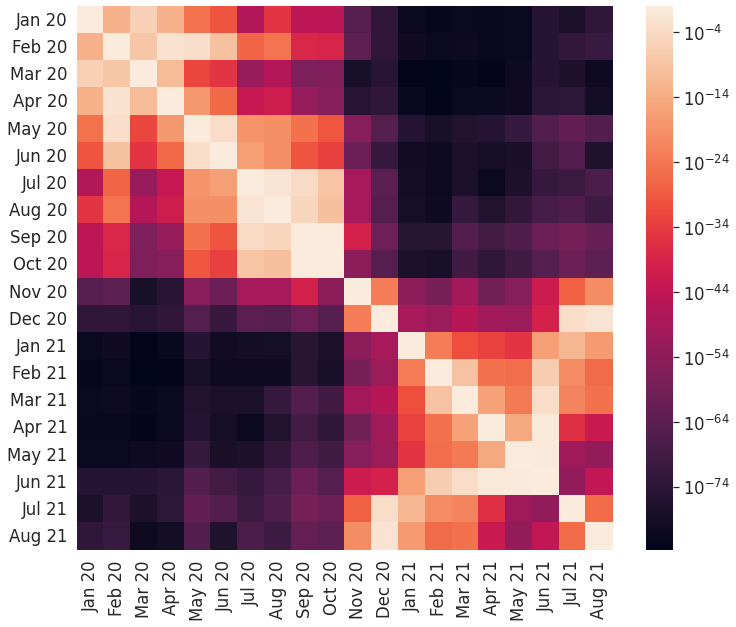

In [31]:
f, ax = plt.subplots(figsize=(12, 10))
sns.set(font_scale = 1.5)
months = ['Jan 20', 'Feb 20', 'Mar 20','Apr 20','May 20','Jun 20', 'Jul 20', 'Aug 20', 'Sep 20', 'Oct 20', 'Nov 20', 'Dec 20', 'Jan 21', 'Feb 21', 'Mar 21','Apr 21','May 21','Jun 21', 'Jul 21', 'Aug 21']

heatmap = sns.heatmap(p_array, norm=LogNorm(), xticklabels=months, yticklabels=months)

fig = heatmap.get_figure()
fig.savefig('Wilcoxon matrix', format='svg')

In [32]:
pd.DataFrame({month: list(month_array[i]) for i, month in enumerate(months)})


,Jan 20,Feb 20,Mar 20,Apr 20,May 20,Jun 20,Jul 20,Aug 20,Sep 20,Oct 20,Nov 20,Dec 20,Jan 21,Feb 21,Mar 21,Apr 21,May 21,Jun 21,Jul 21,Aug 21
0,0.0,0.003821,0.0,0.001786,0.0,0.005893,0.005571,0.005250,0.010750,0.006071,0.004929,0.015250,0.025679,0.034429,0.042821,0.058393,0.075750,0.109857,0.075107,0.068750
1,0.0,0.003690,0.0,0.001724,0.0,0.005690,0.003586,0.006897,0.010379,0.008000,0.004759,0.013276,0.023310,0.028034,0.032069,0.048724,0.062310,0.099517,0.066172,0.060690
2,0.0,0.003690,0.0,0.001724,0.0,0.005690,0.005379,0.006897,0.010379,0.008000,0.004759,0.014724,0.026241,0.036586,0.047379,0.057034,0.073724,0.106241,0.078483,0.072069
3,0.0,0.003344,0.0,0.001563,0.0,0.005156,0.006500,0.006250,0.009406,0.007250,0.004313,0.013344,0.023781,0.032500,0.042313,0.049844,0.063438,0.092844,0.068281,0.063781
4,0.0,0.003690,0.0,0.001724,0.0,0.007586,0.007172,0.006897,0.016931,0.010138,0.017414,0.027897,0.052517,0.067655,0.085276,0.083000,0.095414,0.118621,0.076793,0.067310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,0.0,0.000000,0.0,0.000000,0.0,0.004231,0.000000,0.000000,0.000000,0.000000,0.005769,0.009692,0.005577,0.007077,0.007154,0.006692,0.004962,0.001846,0.001154,0.005308
504,0.0,0.000000,0.0,0.000000,0.0,0.005500,0.000000,0.000000,0.000000,0.000000,0.005000,0.008400,0.005900,0.007300,0.006600,0.007300,0.005700,0.001600,0.001500,0.006900
505,0.0,0.000000,0.0,0.000000,0.0,0.006111,0.000000,0.000000,0.000000,0.000000,0.005556,0.009333,0.006556,0.008111,0.007333,0.008111,0.006333,0.001778,0.001667,0.007667
506,0.0,0.000000,0.0,0.000000,0.0,0.007174,0.000000,0.000000,0.000000,0.000000,0.006522,0.010957,0.006739,0.008478,0.008087,0.009522,0.007435,0.002087,0.001957,0.009000


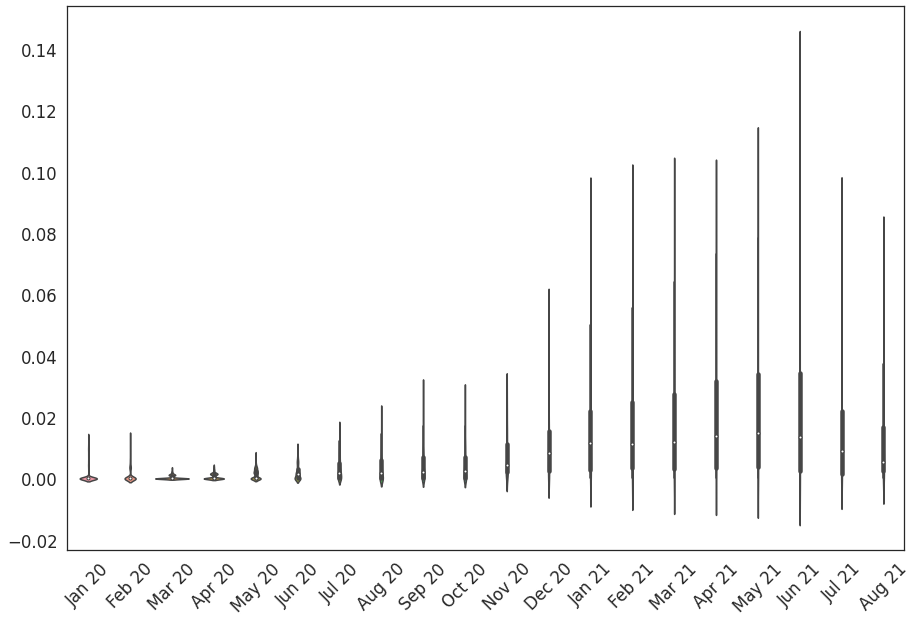

In [33]:
df = pd.DataFrame({month: list(month_array[i]) for i, month in enumerate(months)})
sns.set_style("white")
f, ax = plt.subplots(figsize=(15, 10))
sns.set(font_scale = 1.5)
sns.violinplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

plt.show()